<a href="https://colab.research.google.com/github/Ed-Cheng/Moving-avg-trading-strategy/blob/main/MA_trading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Key functions & initializing stock 

In [1]:
# !pip install yfinance

In [2]:
import copy

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,6)

from pandas_datareader import data
from datetime import datetime


In [3]:
class Stock_holding():
  """ This class stores the holdings and info of a stock """
  def __init__(self, stock):
    """ Format the stock and initialize the fund. Fund can be changed later """
    self.info = stock
    self.timeframe = len(stock.index)
    self.initialize_fund(1000, 30)

  def add_MA(self, days):
    self.info[f"MA{days}"] = self.info["Close"].rolling(days).mean()

  def add_EMA(self, days):
    self.info[f"EMA{days}"] = self.info["Close"].ewm(span=days, adjust=False).mean()
  
  def initialize_fund(self, amount, period):
    """ add investment funds and places to record tradings """
    deposit = np.tile(np.append([amount], np.zeros(period - 1)), self.timeframe//period + 1)
    self.info["deposit"] = deposit[:self.timeframe]
    self.info["share"] = np.zeros(self.timeframe)
    self.info["worth"] = np.zeros(self.timeframe)

  def update_deposit(self, idx):
    """ during trading, today deposit = yesterday remaining """
    self.info.loc[idx,"deposit"] += self.info.loc[idx-1,"deposit"]
    self.info.loc[idx,"share"] += self.info.loc[idx-1,"share"]

  def buy(self, idx):
    """ buy shares according to remaining cash """
    buy_shares = self.info.loc[idx,"deposit"] // self.info.loc[idx,"Open"]
    self.info.loc[idx,"share"] += buy_shares
    self.info.loc[idx,"deposit"] -= buy_shares * self.info.loc[idx,"Open"]

  def sell(self, idx):
    self.info.loc[idx,"deposit"] += self.info.loc[idx,"share"] * self.info.loc[idx,"Open"]
    self.info.loc[idx,"share"] = 0

  def update_worth(self, idx):
    self.info.loc[idx,"worth"] = self.info.loc[idx,"deposit"] + self.info.loc[idx,"share"]*self.info.loc[idx,"Close"]


def store_stock_data(target_stock, start_date, end_date):
  """ read the stock data from yahoo and store it to csv """
  # convert to pandasreader format
  yf.pdr_override()

  # read and save pandas df
  df = data.get_data_yahoo([target_stock], start_date, end_date)
  df.to_csv(f"./{target_stock}.csv")


def initialize_stock_holding(target_stock):
  """ Read the stock csv files and only keep the info we need """
  # read csv file  
  df = pd.read_csv(f"{target_stock}.csv")
  # fill in missing values, if any
  df = df.interpolate()
  # only take the values needed
  df = df[["Date", "Open", "Close", "Volume"]]

  holding = Stock_holding(df)

  return holding


def initialize_indicator(holding):
  """ These are the main indicators we will be using """
  holding.add_MA(20)
  holding.add_MA(50)
  holding.add_MA(200)
  holding.add_EMA(20)

Here we load the desired stock data 
- 0050.tw is the Taiwan Top-50 ETF 
- 00618L.tw is the Bull 2X on 0050.tw

In [4]:
start_date = datetime(2015, 1, 1)
end_date = datetime(2023, 1, 1) 

store_stock_data("0050.TW", start_date, end_date)
store_stock_data("00631L.TW", start_date, end_date)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
tw0050 = initialize_stock_holding("0050.TW")
tw00631L = initialize_stock_holding("00631L.TW")

initialize_indicator(tw0050)
initialize_indicator(tw00631L)

<Axes: xlabel='Date'>

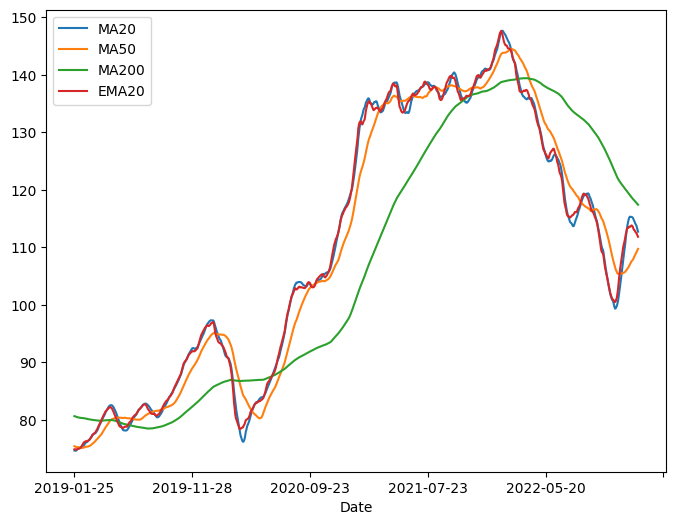

In [6]:
tw0050.info.loc[tw0050.info.index >= 1000].plot(x="Date", y=["MA20","MA50", "MA200", "EMA20"])

# Baseline: dollar cost averaging (DCA)

In [7]:
def simple_dca(trade_stock, start_date, end_date):
  """ 
    The baseline strategy, dollar cost averaging 
    Always buy when cash available 
    Never sell
  """

  for tdy in trade_stock.info.index[start_date:end_date]:
    yda = tdy - 1
    trade_stock.update_deposit(tdy)

    # check buy signal 
    if trade_stock.info.loc[tdy,"deposit"] > trade_stock.info.loc[tdy,"Open"]:
      # buy
      trade_stock.buy(tdy)
    
    trade_stock.update_worth(tdy)

  return trade_stock


def savings_account(trade_stock, start_date, end_date):
  """ 
    Putting money in the bank
    Assume 2% interest rate per year (240 trading days)
  """

  for tdy in trade_stock.info.index[start_date:end_date]:
    trade_stock.update_deposit(tdy)
    
    if (tdy - start_date) % 240 == 0:
      # add 2% interest rate to today"s deposit
      trade_stock.info.loc[tdy,"deposit"] *= 1.02

    trade_stock.update_worth(tdy)
    
  return trade_stock

# Strategy 1: Trading on 20MA/20EMA

In [8]:
def strategy1(trade_stock, signal_stock, start_date, end_date):
  """
    The initial MA trading strategy
    Has 2 trading rules:
    1. Buy when satisfied all conditions:
      - 20 ema > 20 ma (exp month buying stronger than avg month buying)
      - 20 ema is greater than yesterday (month trend going upwards)
      - have sufficient cash
    2. Sell when satisfied all conditions:
      - 20 ema < 20 ma (exp month buying weaker than avg month buying)
  """  

  for tdy in signal_stock.info.index[start_date:end_date]:
    yda = tdy - 1
    trade_stock.update_deposit(tdy)

    # buy signal according to yesterday"s stats
    if (signal_stock.info.loc[yda,"EMA20"] > signal_stock.info.loc[yda,"MA20"] and
        signal_stock.info.loc[yda,"EMA20"] > signal_stock.info.loc[yda-1,"EMA20"] and 
        trade_stock.info.loc[tdy,"deposit"] > trade_stock.info.loc[tdy,"Open"]): 
      # buy
      trade_stock.buy(tdy)

    # sell signal according to yesterday"s stats
    elif signal_stock.info.loc[yda,"EMA20"] < signal_stock.info.loc[yda,"MA20"]:
      # sell
      trade_stock.sell(tdy)
    
    trade_stock.update_worth(tdy)

  return trade_stock

In [9]:
def compare_worth(info_list):
  """
    Plots the final worth of different strategy
    
    Takes a list of lists
    In the lists, first arg is the strategy"s name
    second arg is the dataframe that stores trading info
  """
  date_time = info_list[0][1]["Date"].values
  date_time = pd.to_datetime(date_time)

  df_for_plotting = pd.DataFrame()
  for i in range(len(info_list)):
    df_for_plotting[info_list[i][0]] = info_list[i][1]["worth"].values

  df_for_plotting = df_for_plotting.set_index(date_time)

  plt.figure()
  plt.plot(df_for_plotting)
  plt.gcf().autofmt_xdate()
  plt.legend(df_for_plotting.keys());
  plt.show()

def analyse_worth(info_list):
  """
    Compare the final worth diff in percentage. 
    Takes the first strategy in the list as the baseline.
  """
  print(f"Take {info_list[0][0]} as the baseline:")
  baseline = info_list[0][1]['worth'].iloc[-1]
  for i in range(1, len(info_list)):
    strategy_result = info_list[i][1]['worth'].iloc[-1]
    diff_percentage = ((strategy_result/baseline) - 1)*100

    print(f"Apply {info_list[i][0]}:\t{np.round(diff_percentage, 2)}%")


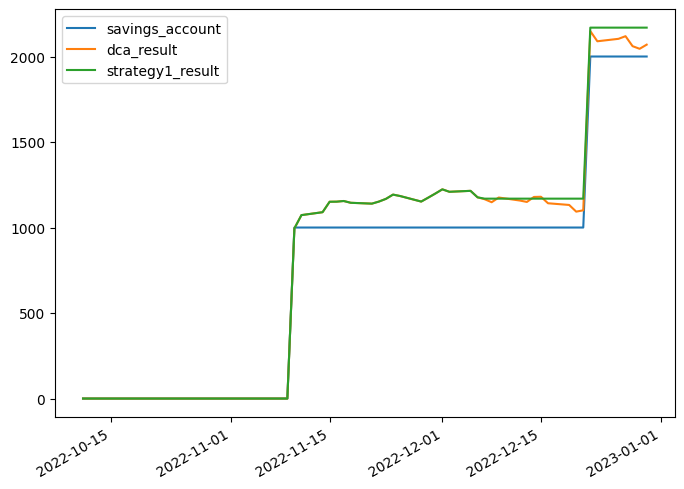

Take savings_account as the baseline:
Apply dca_result:	3.47%
Apply strategy1_result:	8.44%


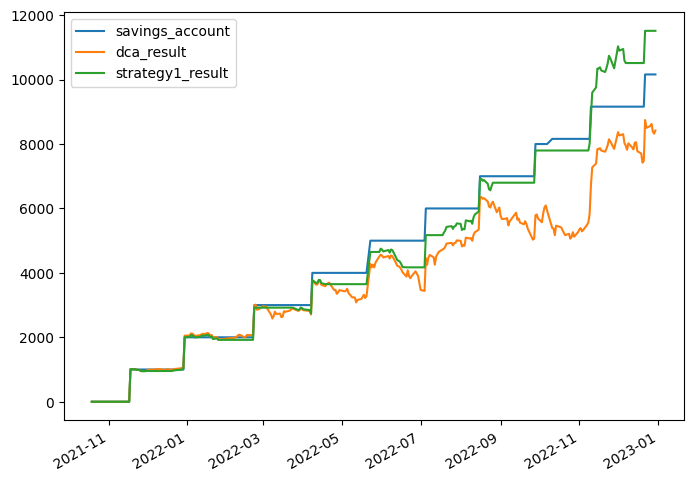

Take savings_account as the baseline:
Apply dca_result:	-17.12%
Apply strategy1_result:	13.33%


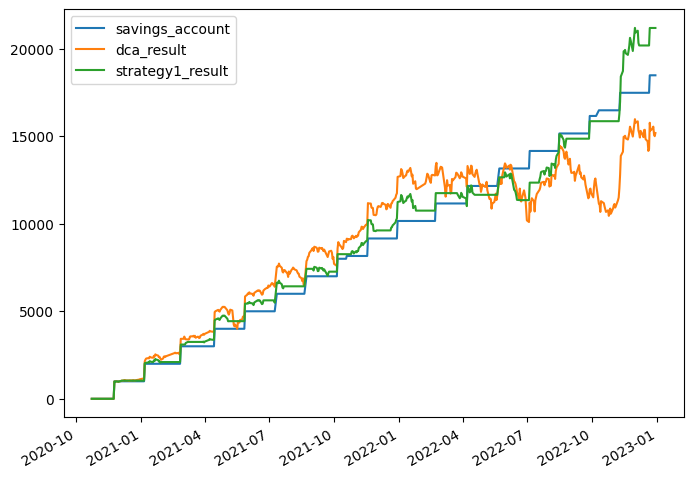

Take savings_account as the baseline:
Apply dca_result:	-17.85%
Apply strategy1_result:	14.63%


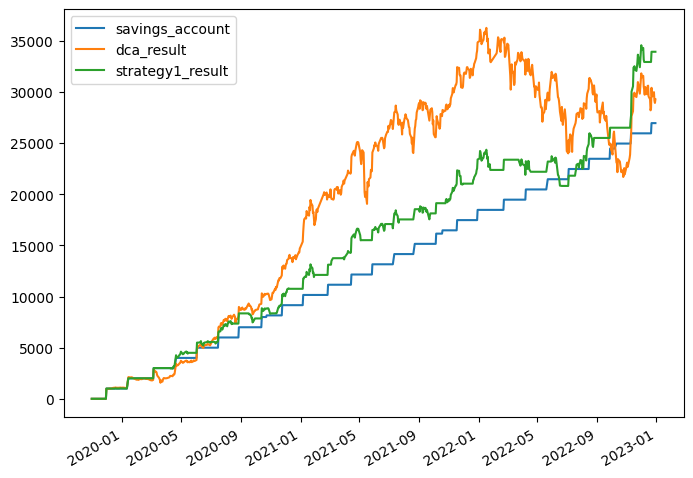

Take savings_account as the baseline:
Apply dca_result:	8.6%
Apply strategy1_result:	25.88%


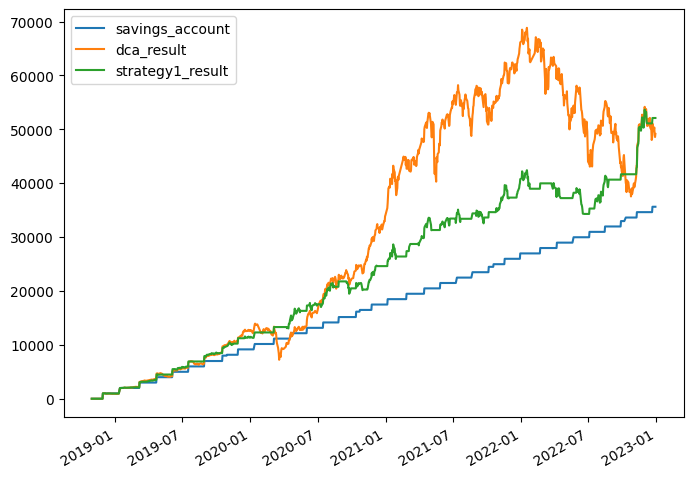

Take savings_account as the baseline:
Apply dca_result:	37.96%
Apply strategy1_result:	46.24%


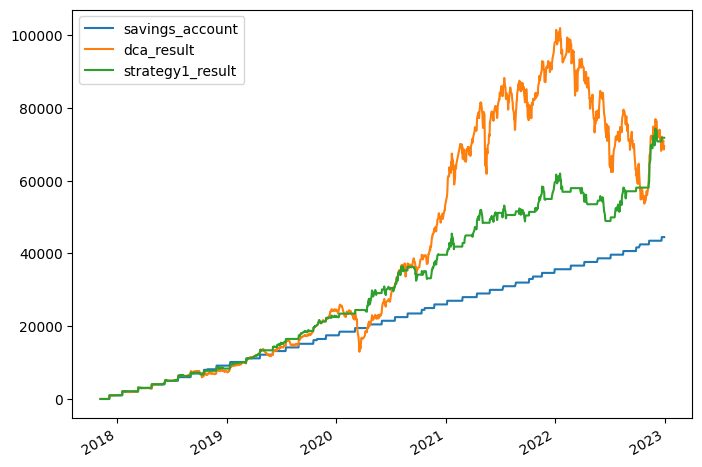

Take savings_account as the baseline:
Apply dca_result:	55.96%
Apply strategy1_result:	61.34%


In [10]:
trading_days_qtr = 60

# start from one trading qtr, compare up to 6 years
data_range = np.arange(trading_days_qtr, trading_days_qtr*4*6, trading_days_qtr*4)
full_date_range = tw0050.timeframe

for days in data_range:
  info_list = []

  trade_stock = copy.deepcopy(tw00631L)
  savings_account_result = savings_account(trade_stock, full_date_range-days, full_date_range-1)
  info_list.append(["savings_account", savings_account_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  dca_result = simple_dca(trade_stock, full_date_range-days, full_date_range-1)
  info_list.append(["dca_result", dca_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  strategy1_result = strategy1(trade_stock, tw0050, full_date_range-days, full_date_range-1)
  info_list.append(["strategy1_result", strategy1_result.info.loc[full_date_range-days:]])

  compare_worth(info_list)
  analyse_worth(info_list)


# Analysis & Strategy Update 1 



## Analysis
1. From observation, strategy 1 works better in bear market.
2. Strategy 1 has the potential of making profit even in the bear market, while dca experience massive drawdown.
3. Overall, strategy 1 is a relatively sound investment strategy. The net worth grows slower in bull markets but also prevents huge loss in bear markets.


## Strategy Update
1. Implement dca in bull markets and strategy 1 in bear markets
2. Determine bull/bear markets by checking the crossovers of 50 ma and 200 ma (Sources: Nasdaq) https://www.nasdaq.com/articles/using-modern-techniques-identify-bear-market-2011-10-05

# Strategy 2: Apply strategy 1 & dca depending on bull/bear

In [11]:
def strategy2(trade_stock, signal_stock, start_date, end_date):
  """
    Determine bull/bear market by the crossing of 50ma and 200 ma
    During bull marktet, apply dca
    During bear market, apply strategy 1
  """  

  for tdy in signal_stock.info.index[start_date:end_date]:
    yda = tdy - 1
    trade_stock.update_deposit(tdy)

    # Apply dca during bull market
    if signal_stock.info.loc[yda,"MA50"] > signal_stock.info.loc[yda,"MA200"]:
      # check buy signal 
      if trade_stock.info.loc[tdy,"deposit"] > trade_stock.info.loc[tdy,"Open"]:
        # buy
        trade_stock.buy(tdy)

    # Apply strategy 1 during bear market
    else:
      # buy signal according to yesterday"s stats
      if (signal_stock.info.loc[yda,"EMA20"] > signal_stock.info.loc[yda,"MA20"] and
          signal_stock.info.loc[yda,"EMA20"] > signal_stock.info.loc[yda-1,"EMA20"] and 
          trade_stock.info.loc[tdy,"deposit"] > trade_stock.info.loc[tdy,"Open"]): 
        # buy
        trade_stock.buy(tdy)

      # sell signal according to yesterday"s stats
      elif signal_stock.info.loc[yda,"EMA20"] < signal_stock.info.loc[yda,"MA20"]:
        # sell
        trade_stock.sell(tdy)
    
    trade_stock.update_worth(tdy)

  return trade_stock

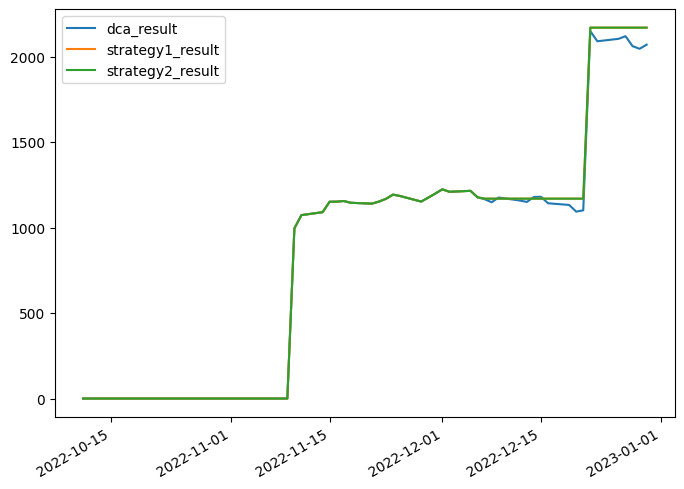

Take dca_result as the baseline:
Apply strategy1_result:	4.81%
Apply strategy2_result:	4.81%


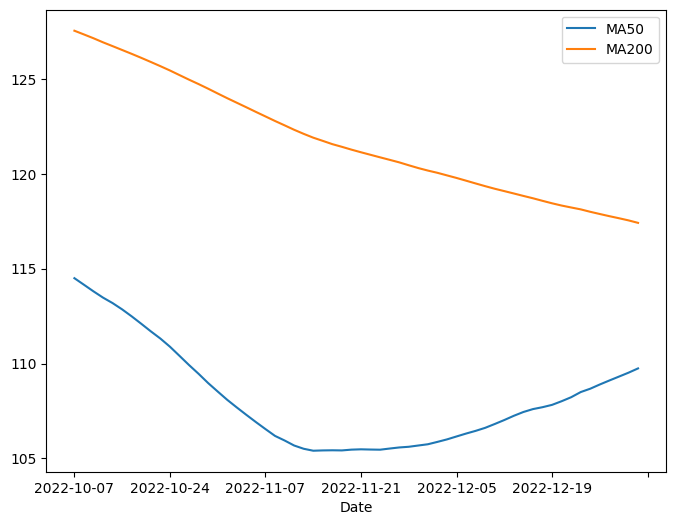

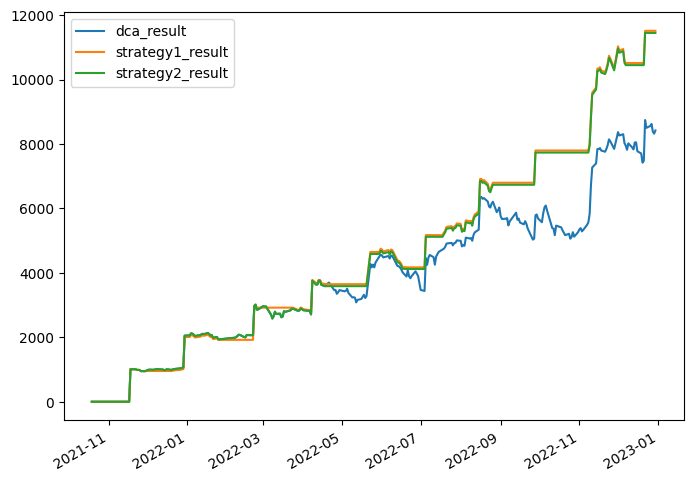

Take dca_result as the baseline:
Apply strategy1_result:	36.74%
Apply strategy2_result:	35.96%


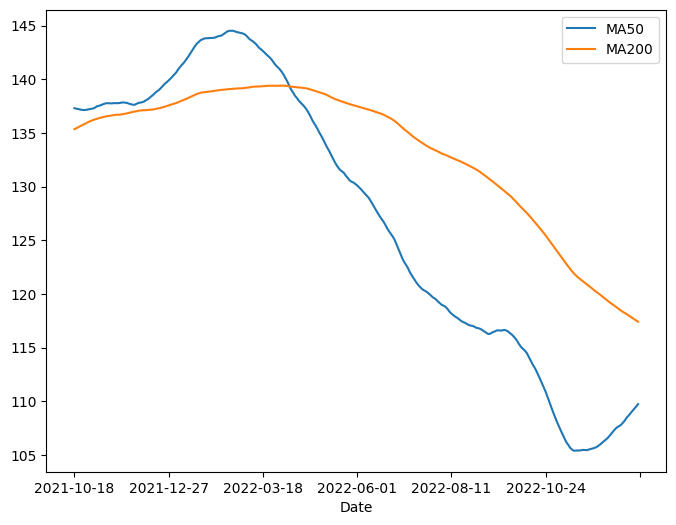

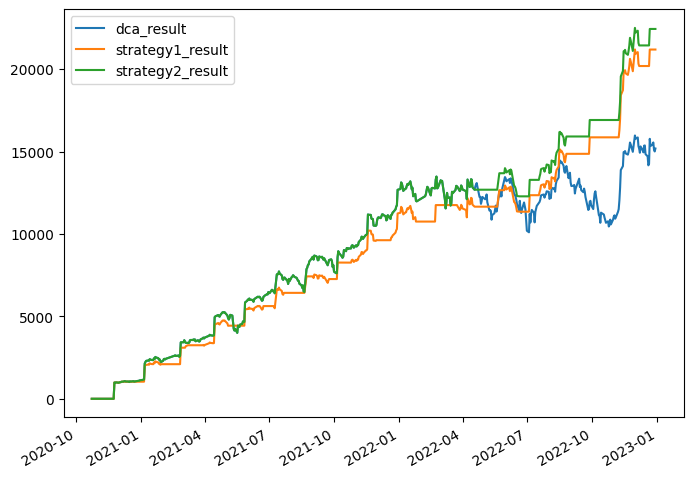

Take dca_result as the baseline:
Apply strategy1_result:	39.54%
Apply strategy2_result:	47.77%


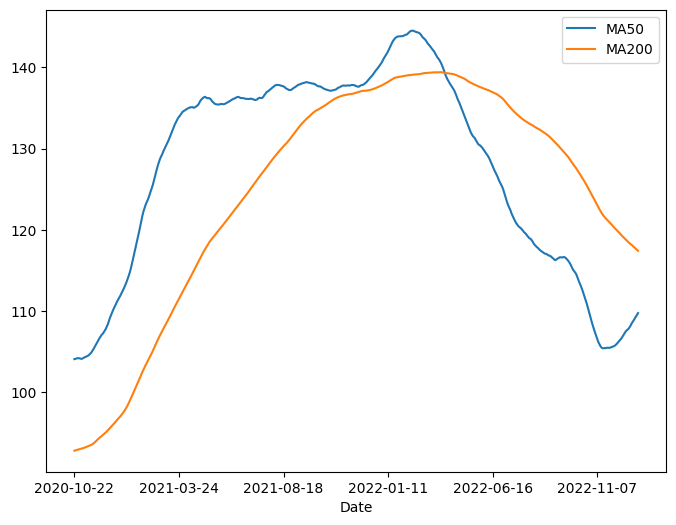

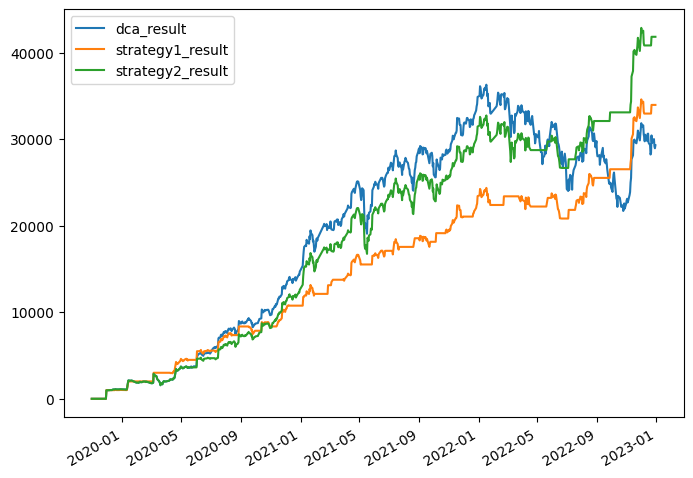

Take dca_result as the baseline:
Apply strategy1_result:	15.91%
Apply strategy2_result:	42.78%


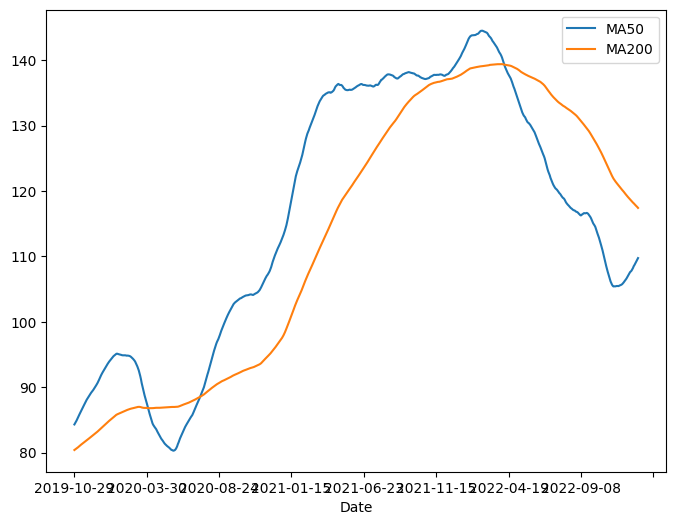

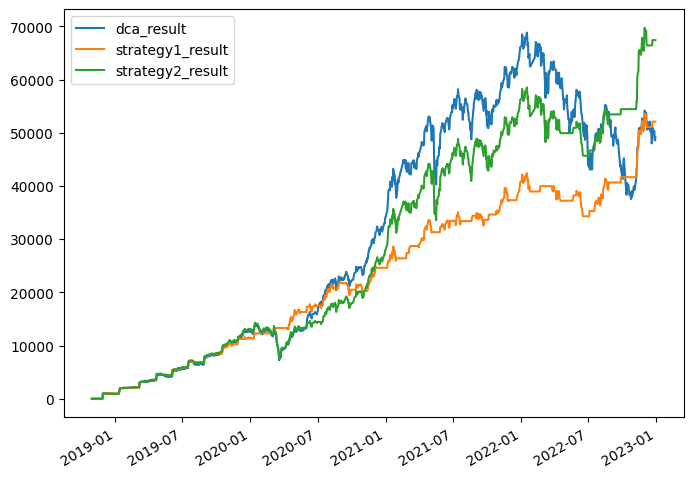

Take dca_result as the baseline:
Apply strategy1_result:	6.0%
Apply strategy2_result:	37.19%


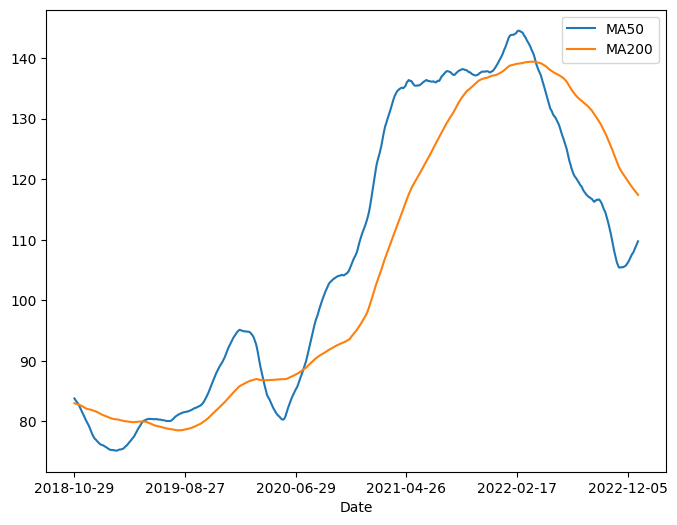

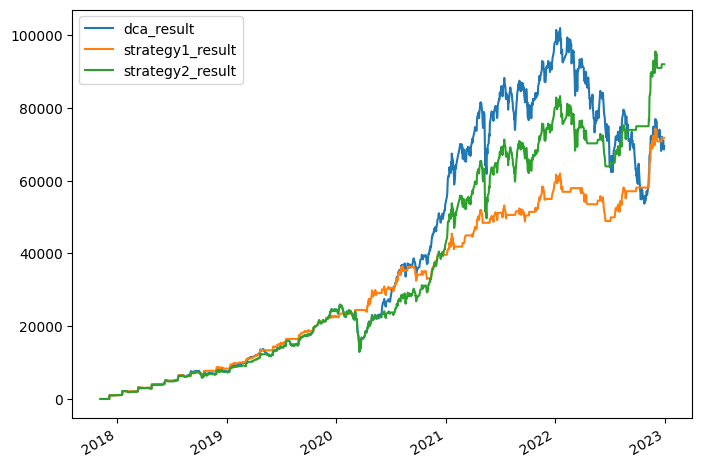

Take dca_result as the baseline:
Apply strategy1_result:	3.45%
Apply strategy2_result:	32.56%


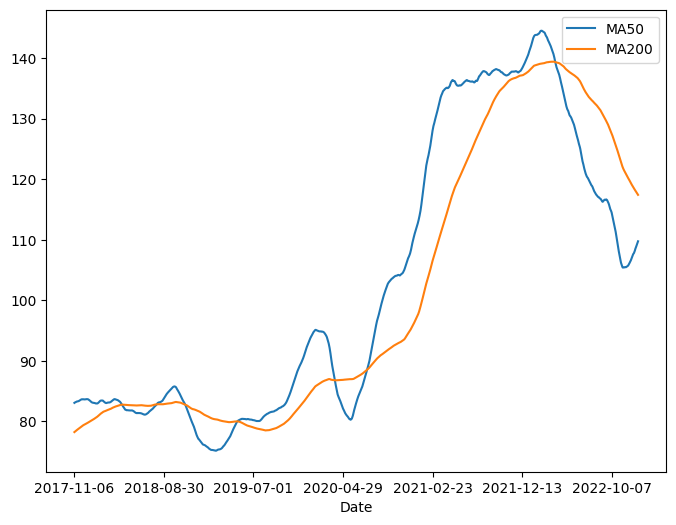

In [12]:
trading_days_qtr = 60

# start from one trading qtr, compare up to 6 years
data_range = np.arange(trading_days_qtr, trading_days_qtr*4*6, trading_days_qtr*4)
full_date_range = tw0050.timeframe

for days in data_range:
  info_list = []

  trade_stock = copy.deepcopy(tw00631L)
  dca_result = simple_dca(trade_stock, full_date_range-days, full_date_range-1)
  info_list.append(["dca_result", dca_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  strategy1_result = strategy1(trade_stock, tw0050, full_date_range-days, full_date_range-1)
  info_list.append(["strategy1_result", strategy1_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  strategy2_result = strategy2(trade_stock, tw0050, full_date_range-days, full_date_range-1)
  info_list.append(["strategy2_result", strategy2_result.info.loc[full_date_range-days:]])

  compare_worth(info_list)
  analyse_worth(info_list)
  tw0050.info.loc[tw0050.info.index >= full_date_range-days].plot(x="Date", y=["MA50","MA200"])

# Analysis & Strategy Update 2


## Analysis
1. Strategy 2 out-performs strategy 1, meaning we are on the right track.
2. Although strategy 2 successfully avoided some of the drawdowns in bear market, it indicates one of the biggest disadvantage of MA trading: MA or EMA are both lagging indicators.
3. Overall, mixed strategy is valid, but requires a better way of detecting bull/bear market.


## Strategy Update 2-1
1. I came up with an idea that I could take the maximum price over the past few trading days and see if the market is bullish or bearish. 
2. View the following examples

In [13]:
def periodic_max(stock_df, ma, period):
  """ gives the peak value of the ma over a given period"""
  stock_df[f"{ma}_pmax"] = stock_df[ma].rolling(period).max()


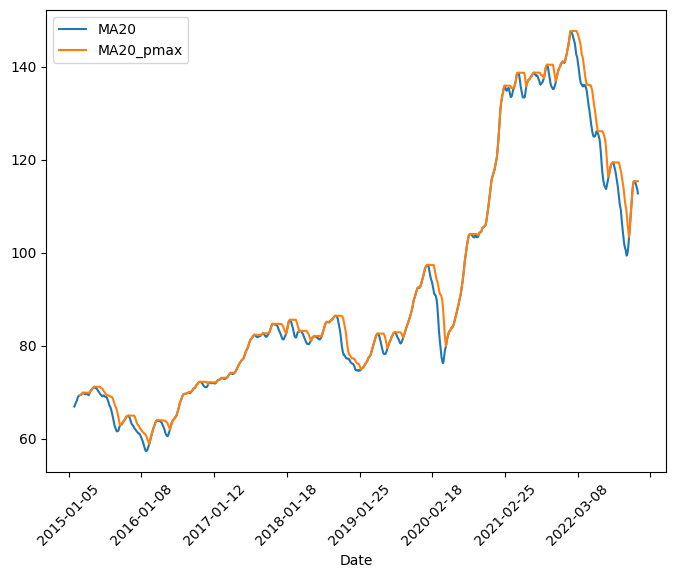

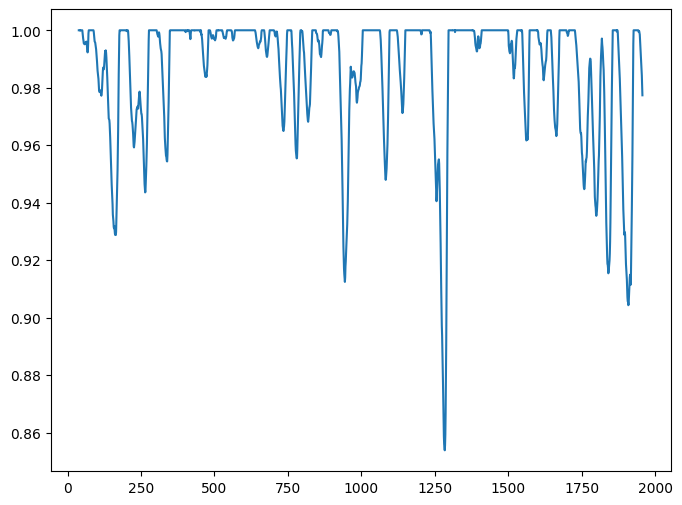

In [14]:
# The peak value over the past trading month of MA20
periodic_max(tw0050.info, "MA20", 20)
tw0050.info.plot(x="Date", y=["MA20", "MA20_pmax"])
plt.xticks(rotation=45)
plt.show()

percentage = tw0050.info["MA20"] / tw0050.info["MA20_pmax"]
plt.plot(percentage)

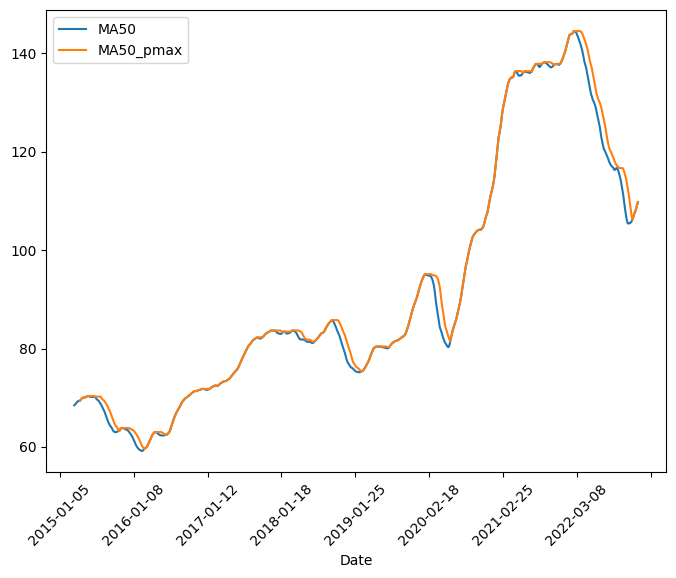

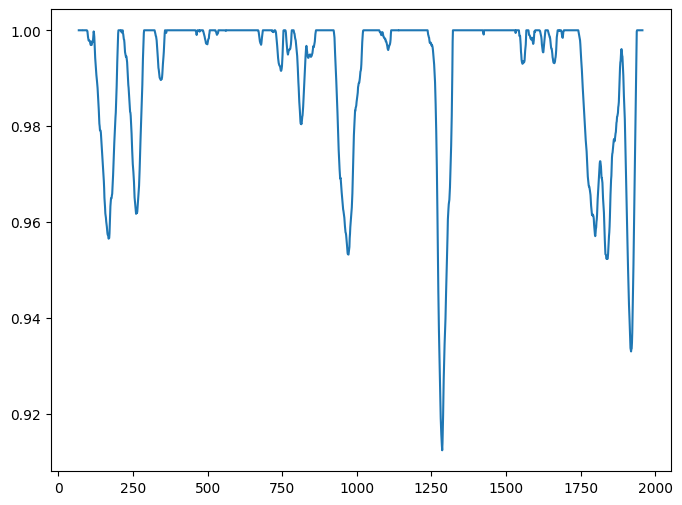

In [15]:
# The peak value over the past trading month of MA50
periodic_max(tw0050.info, "MA50", 20)
tw0050.info.plot(x="Date", y=["MA50", "MA50_pmax"])
plt.xticks(rotation=45)
plt.show()

percentage = tw0050.info["MA50"] / tw0050.info["MA50_pmax"]
plt.plot(percentage)

## Strategy Update 2-2
1. Different MAs give various degree of smoothness
2. Trying to avoid all drawdowns is impractical, as this might also miss a tremendous rebound.
3. From the "percentage" plot we can notice some bearish market and some retracements (minor pullbacks) 
4. Moving on, we could utilize these information to improve strategy 2 

# Strategy 3: Improved bull/bear market indicator

In [16]:
def strategy3(trade_stock, signal_stock, start_date, end_date, indicator, threshold):
  """
    Determine bull/bear market by the periodic maximum of the MAs
    During bull marktet, apply dca
    During bear market, apply strategy 1
  """  

  for tdy in signal_stock.info.index[start_date:end_date]:
    yda = tdy - 1
    trade_stock.update_deposit(tdy)

    # Apply dca during bull market
    if signal_stock.info.loc[yda, indicator] > threshold*signal_stock.info.loc[yda,f"{indicator}_pmax"]:
      # check buy signal 
      if trade_stock.info.loc[tdy,"deposit"] > trade_stock.info.loc[tdy,"Open"]:
        # buy
        trade_stock.buy(tdy)

    # Apply strategy 1 during bear market
    else:
      # buy signal according to yesterday"s stats
      if (signal_stock.info.loc[yda,"EMA20"] > signal_stock.info.loc[yda,"MA20"] and
          # signal_stock.info.loc[yda,"EMA20"] > signal_stock.info.loc[yda-1,"EMA20"] and 
          trade_stock.info.loc[tdy,"deposit"] > trade_stock.info.loc[tdy,"Open"]): 
        # buy
        trade_stock.buy(tdy)

      # sell signal according to yesterday"s stats
      elif signal_stock.info.loc[yda,"EMA20"] < signal_stock.info.loc[yda,"MA20"]:
        # sell
        trade_stock.sell(tdy)
    
    trade_stock.update_worth(tdy)

  return trade_stock

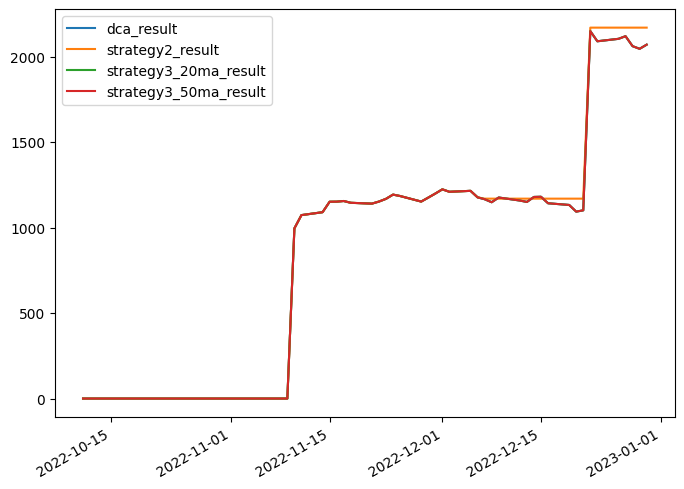

Take dca_result as the baseline:
Apply strategy2_result:	4.81%
Apply strategy3_20ma_result:	0.0%
Apply strategy3_50ma_result:	0.0%


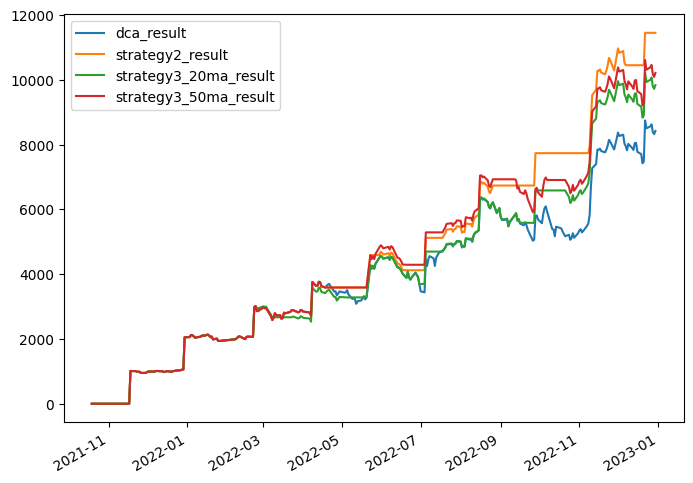

Take dca_result as the baseline:
Apply strategy2_result:	35.96%
Apply strategy3_20ma_result:	16.79%
Apply strategy3_50ma_result:	21.26%


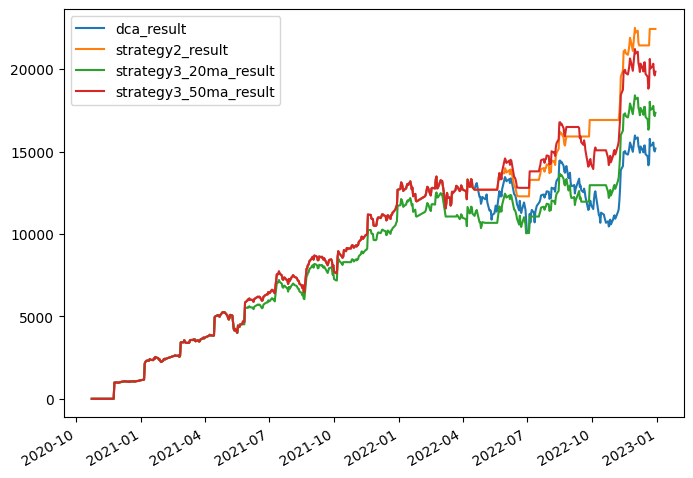

Take dca_result as the baseline:
Apply strategy2_result:	47.77%
Apply strategy3_20ma_result:	14.27%
Apply strategy3_50ma_result:	30.72%


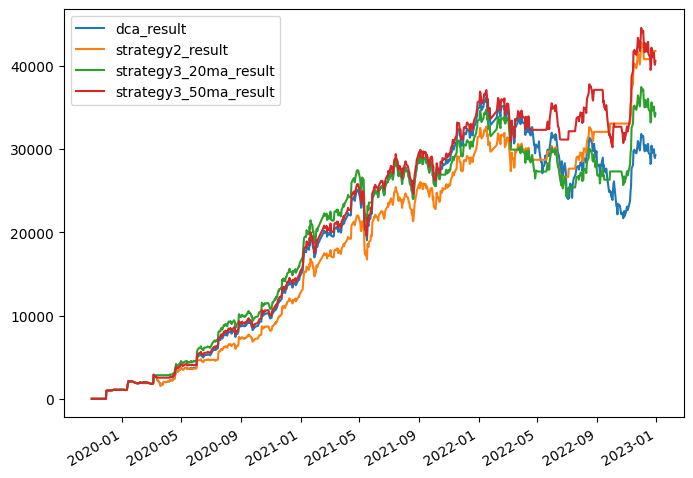

Take dca_result as the baseline:
Apply strategy2_result:	42.78%
Apply strategy3_20ma_result:	17.12%
Apply strategy3_50ma_result:	38.72%


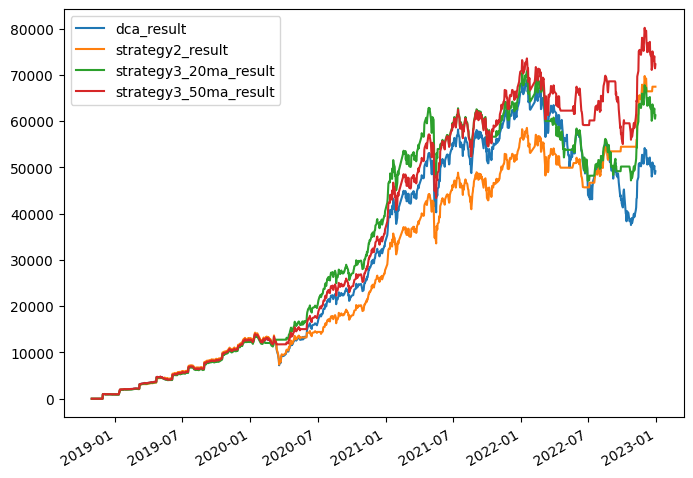

Take dca_result as the baseline:
Apply strategy2_result:	37.19%
Apply strategy3_20ma_result:	24.58%
Apply strategy3_50ma_result:	47.02%


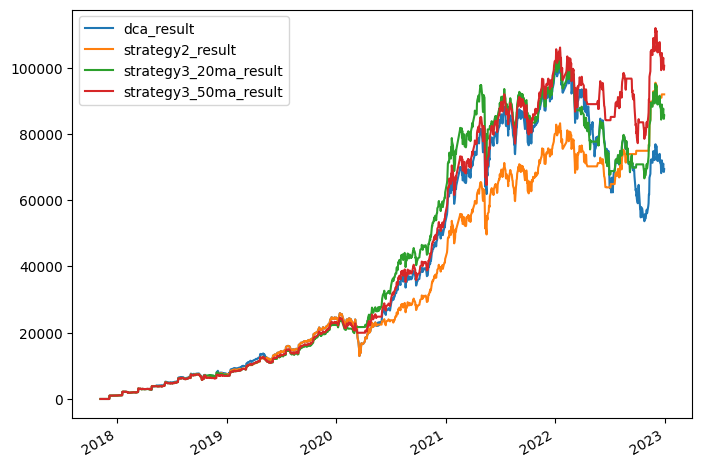

Take dca_result as the baseline:
Apply strategy2_result:	32.56%
Apply strategy3_20ma_result:	23.38%
Apply strategy3_50ma_result:	44.97%


In [17]:
trading_days_qtr = 60

# start from one trading qtr, compare up to 6 years
data_range = np.arange(trading_days_qtr, trading_days_qtr*4*6, trading_days_qtr*4)
full_date_range = tw0050.timeframe

for days in data_range:
  info_list = []

  trade_stock = copy.deepcopy(tw00631L)
  dca_result = simple_dca(trade_stock, full_date_range-days, full_date_range-1)
  info_list.append(["dca_result", dca_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  strategy2_result = strategy2(trade_stock, tw0050, full_date_range-days, full_date_range-1)
  info_list.append(["strategy2_result", strategy2_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  strategy3_20ma_result = strategy3(trade_stock, tw0050, full_date_range-days, full_date_range-1, "MA20", 0.98)
  info_list.append(["strategy3_20ma_result", strategy3_20ma_result.info.loc[full_date_range-days:]])

  trade_stock = copy.deepcopy(tw00631L)
  strategy3_50ma_result = strategy3(trade_stock, tw0050, full_date_range-days, full_date_range-1, "MA50", 0.985)
  info_list.append(["strategy3_50ma_result", strategy3_50ma_result.info.loc[full_date_range-days:]])

  compare_worth(info_list)
  analyse_worth(info_list)



# Analysis & Strategy Update 3
 

## Analysis
1. From the above results, the strategy is feasible.
2. The next step will be fine tuning the parameters

> **Important Note**: Past performance do not indicate future performance. Fine tuning might overfit past performance and executes poorly in the future.

# Fine tuning via grid search

Before fine tuning, the "goal" has to be clear.

The goal for this fine tuning session is to get the highest worth over the given period of time (till newest date). So the only factor this session cares will be the final worth.

In [18]:
def fine_tune_strategy3(ma_choice: str, period_peak: int, threshold: int):
  """ Fine tune strategy3 over three factors: ma choice, peak over period, threshold"""
  periodic_max(tw0050.info, ma_choice, period_peak)

  trading_days_qtr = 60

  data_range = np.arange(trading_days_qtr, trading_days_qtr*4*6, trading_days_qtr*4)
  full_date_range = tw0050.timeframe

  fine_tune_result = [f"{ma_choice}_{period_peak}_{threshold}"]

  for days in data_range:
    trade_stock = copy.deepcopy(tw00631L)
    fine_tune = strategy3(trade_stock, tw0050, full_date_range-days, full_date_range-1, ma_choice, threshold)
    fine_tune_result.append(fine_tune.info.iloc[-1]["worth"])
  return fine_tune_result

def fine_tune_process(ma_options, period_options, threshold_options):
  """ Using grid search as the fine tuning process """
  results = []
  for ma in ma_options:
    for period in period_options:
      for threshold in threshold_options:
        results.append(fine_tune_strategy3(ma, period, threshold))
  return results

def rank_tuning_result(tuning_result):
  """ 
    For each result column, rank them according to the values (large to small)
    Ranking from the last column to the second column
  """
  ranking = {}

  # Note j goes from the last column to the first column
  # Ranking from the most significant value to the least significant
  for j in np.arange(len(tuning_result[0]) - 1, 0, -1):
    # Sort the list according to diff colomn, values large to small
    tuning_result.sort(key = lambda i: i[j], reverse=True)

    # Note that some values might be the same even after sorted
    worth = tuning_result[0][j]
    rank = 1
    # Record the top 30% performance
    for _, item in enumerate(tuning_result[:int(len(tuning_result)*0.3)]):
      # First, check the ranking 
      if item[j] < worth:
        rank += 1

      # Next, store the rankings of the result
      if item[0] in ranking:
        ranking[item[0]].append(rank)
      else:
        ranking[item[0]] = [rank]
  return ranking

def analyse_ranking(ranking, result_len):
  """ Analyze the rankings of each result """
  for k in ranking.keys():
    print(f"{k} {ranking[k]}", end = "\t")
    if len(ranking[k]) < result_len:
      print("Ignored")
    else:
      # Display the average ranking and the standard deviation  
      print(f"Avg ranking: {round(np.mean(ranking[k]), 2)}", end=" ")
      print(f"Std: {round(np.std(ranking[k]), 2)}")

## Initial grid search (coarse-grained grids)

To start the fine tuning, I started with a loose grid. The values will be refined later.

In [19]:
ma_options = ["MA50", "MA20"]
# Note arange do not include endpoints
period_options = np.arange(20, 61, 5)
threshold_options = np.arange(0.979, 0.995, 0.003)

tuning_result_1 = fine_tune_process(ma_options, period_options, threshold_options)

In [20]:
tuning_result_ranked_1 = rank_tuning_result(tuning_result_1)
analyse_ranking(tuning_result_ranked_1, len(tuning_result_1[0]) - 1)

MA50_45_0.991 [1, 1, 1, 2, 2, 1]	Avg ranking: 1.33 Std: 0.47
MA50_50_0.991 [2, 2, 7, 19, 19, 14]	Avg ranking: 10.5 Std: 7.23
MA50_55_0.991 [3, 3, 8, 20, 20, 15]	Avg ranking: 11.5 Std: 7.23
MA50_40_0.991 [4, 4, 11, 25, 28, 25]	Avg ranking: 16.17 Std: 10.16
MA50_35_0.991 [5, 10, 17, 29]	Ignored
MA50_45_0.988 [6, 9, 2, 1, 1, 1]	Avg ranking: 3.33 Std: 3.09
MA50_60_0.991 [7, 11, 14, 21, 21, 16]	Avg ranking: 15.0 Std: 5.07
MA50_45_0.985 [8, 7, 5, 12, 15, 20]	Avg ranking: 11.17 Std: 5.15
MA50_40_0.985 [9, 6, 6, 14, 17, 22]	Avg ranking: 12.33 Std: 5.91
MA50_40_0.988 [10, 13, 13, 18, 18, 23]	Avg ranking: 15.83 Std: 4.3
MA50_55_0.985 [11, 5, 3, 3, 3, 2]	Avg ranking: 4.5 Std: 3.04
MA50_50_0.985 [12, 8, 4, 4, 4, 3]	Avg ranking: 5.83 Std: 3.18
MA50_30_0.991 [13, 17, 28]	Ignored
MA50_55_0.988 [14, 12, 9, 15, 12, 11]	Avg ranking: 12.17 Std: 1.95
MA50_50_0.988 [15, 15, 10, 16, 13, 12]	Avg ranking: 13.5 Std: 2.06
MA50_35_0.985 [16, 14, 15, 26]	Ignored
MA50_35_0.988 [17, 18, 21, 28]	Ignored
MA50_50_0.99

## Final grid search (refined grids)

Refine the grid search over the good performing parameters
- MA50_45_0.991 [1, 1, 1, 2, 2, 1]	Avg ranking: 1.33 Std: 0.47
- MA50_45_0.988 [6, 9, 2, 1, 1, 1]	Avg ranking: 3.33 Std: 3.09

In [21]:
ma_options = ["MA50"]
# Note arange do not include endpoints
period_options = np.arange(43, 48, 1)
threshold_options = np.arange(0.986, 0.994, 0.001)

tuning_result_2 = fine_tune_process(ma_options, period_options, threshold_options)

In [22]:
tuning_result_ranked_2 = rank_tuning_result(tuning_result_2)
analyse_ranking(tuning_result_ranked_2, len(tuning_result_2[0]) - 1)

MA50_44_0.991 [1, 1, 2, 8, 8, 1]	Avg ranking: 3.5 Std: 3.2
MA50_45_0.991 [2, 1, 3, 9, 9, 1]	Avg ranking: 4.17 Std: 3.48
MA50_43_0.991 [3, 3]	Ignored
MA50_45_0.989 [4, 5, 6, 6, 6, 1]	Avg ranking: 4.67 Std: 1.8
MA50_44_0.993 [5, 10, 11, 1]	Ignored
MA50_45_0.99 [6, 6, 7, 7, 7, 1]	Avg ranking: 5.67 Std: 2.13
MA50_47_0.991 [7, 4, 13]	Ignored
MA50_47_0.993 [8]	Ignored
MA50_46_0.991 [9, 9]	Ignored
MA50_44_0.992 [10, 12, 1]	Ignored
MA50_46_0.993 [11]	Ignored
MA50_45_0.987 [12, 7, 4, 2, 2, 1]	Avg ranking: 4.67 Std: 3.82
MA50_46_0.987 [13, 8, 5, 3, 3, 1]	Avg ranking: 5.5 Std: 3.99
MA50_46_0.986 [2, 1, 1, 1, 1]	Ignored
MA50_44_0.986 [11, 10, 10]	Ignored
MA50_45_0.986 [12, 11, 11]	Ignored
MA50_45_0.988 [8, 4, 4, 1]	Ignored
MA50_46_0.988 [9, 5, 5, 1]	Ignored
MA50_47_0.986 [12, 12]	Ignored
MA50_44_0.987 [13]	Ignored
MA50_44_0.994 [10, 1]	Ignored
MA50_45_0.992 [13, 1]	Ignored


Take the following result and do a final comparison:
- MA50_44_0.991 [1, 1, 2, 8, 8, 1]	Avg ranking: 3.5 Std: 3.2



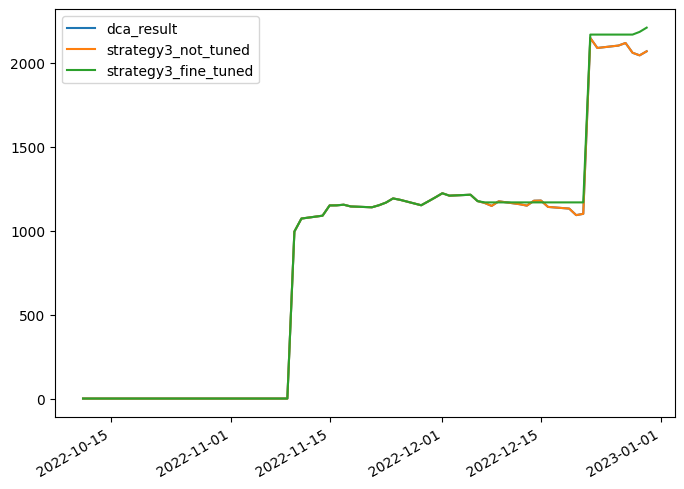

Take dca_result as the baseline:
Apply strategy3_not_tuned:	0.0%
Apply strategy3_fine_tuned:	6.81%


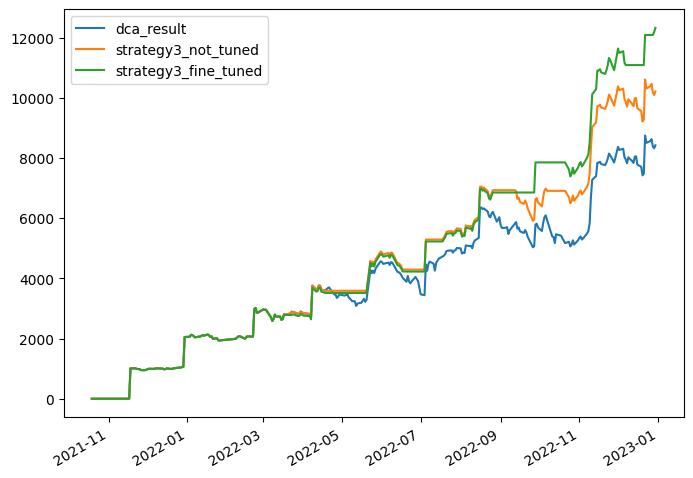

Take dca_result as the baseline:
Apply strategy3_not_tuned:	21.26%
Apply strategy3_fine_tuned:	46.34%


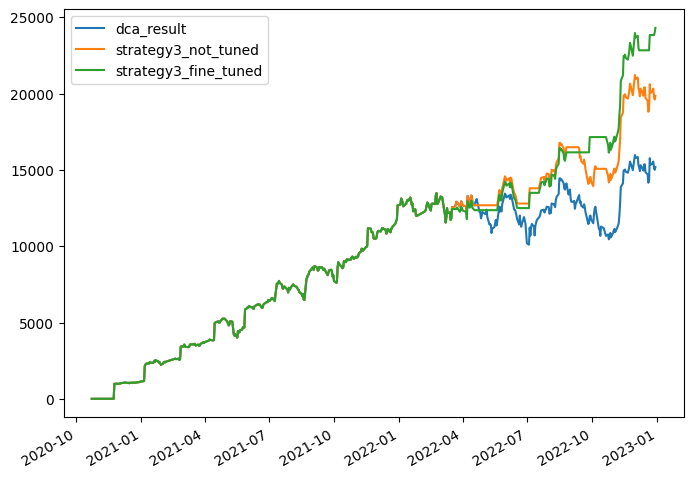

Take dca_result as the baseline:
Apply strategy3_not_tuned:	30.72%
Apply strategy3_fine_tuned:	60.1%


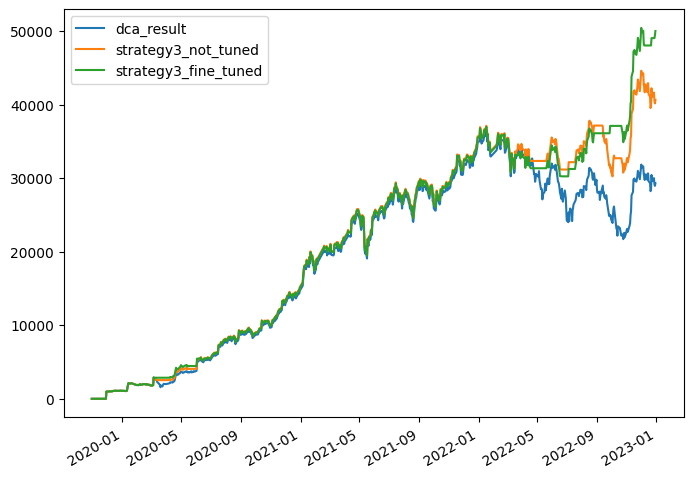

Take dca_result as the baseline:
Apply strategy3_not_tuned:	38.72%
Apply strategy3_fine_tuned:	70.69%


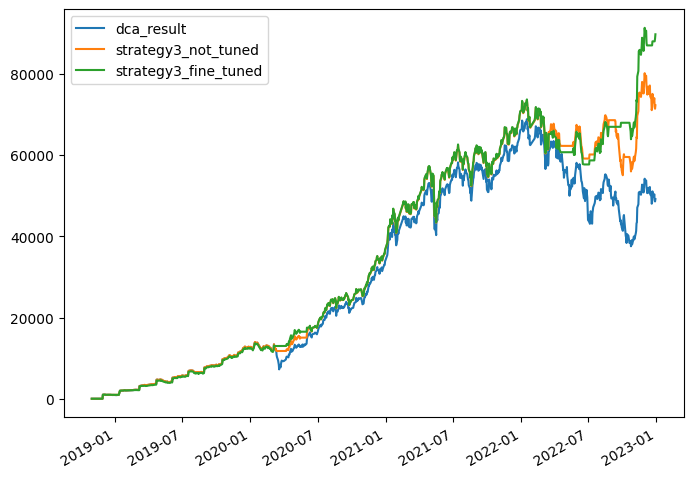

Take dca_result as the baseline:
Apply strategy3_not_tuned:	47.02%
Apply strategy3_fine_tuned:	82.57%


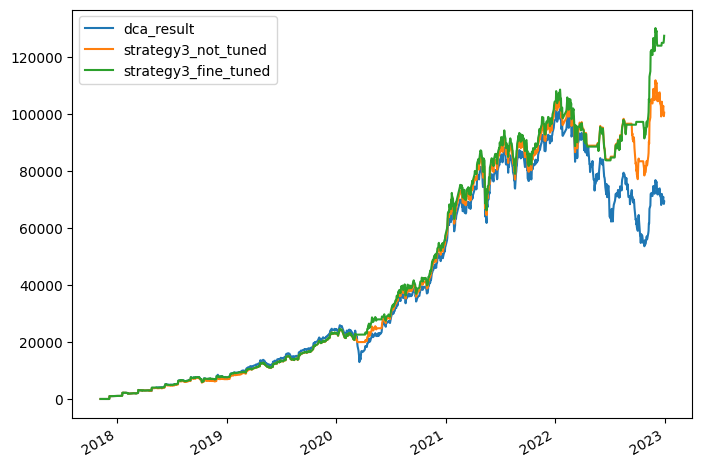

Take dca_result as the baseline:
Apply strategy3_not_tuned:	44.97%
Apply strategy3_fine_tuned:	83.97%


In [23]:
trading_days_qtr = 60

# start from one trading qtr, compare up to 6 years
data_range = np.arange(trading_days_qtr, trading_days_qtr*4*6, trading_days_qtr*4)
full_date_range = tw0050.timeframe

for days in data_range:
  info_list = []

  trade_stock = copy.deepcopy(tw00631L)
  dca_result = simple_dca(trade_stock, full_date_range-days, full_date_range-1)
  info_list.append(["dca_result", dca_result.info.loc[full_date_range-days:]])

  periodic_max(tw0050.info, "MA50", 20)
  trade_stock = copy.deepcopy(tw00631L)
  strategy3_not_tuned = strategy3(trade_stock, tw0050, full_date_range-days, full_date_range-1, "MA50", 0.985)
  info_list.append(["strategy3_not_tuned", strategy3_not_tuned.info.loc[full_date_range-days:]])

  periodic_max(tw0050.info, "MA50", 44)
  trade_stock = copy.deepcopy(tw00631L)
  strategy3_fine_tuned = strategy3(trade_stock, tw0050, full_date_range-days, full_date_range-1, "MA50", 0.991)
  info_list.append(["strategy3_fine_tuned", strategy3_fine_tuned.info.loc[full_date_range-days:]])

  compare_worth(info_list)
  analyse_worth(info_list)


# Final thoughts

- One of Warren Buffett"s investment tips for the average person is to simply invest in index funds, which has also proved effective in growing wealth.
- On the basis of this advice, I carried out an analysis that improved on this simple rule and increased the profit even further.
- The above parameters are specifically tuned for the given situations. Further research and tuning is required to produce a working trading strategy.
